In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler 
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix
# for modeling
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
#Cleaning the dataset
panda = pd.read_excel("lp4.xlsx")
pd1 = (panda['position']).dropna().to_list()
pd2 = panda[["Fx", "Fy", "Fz", "Tx", "Ty", "Tz"]].dropna()
arr = np.array(pd2).flatten().reshape(117,90)
df = pd.DataFrame(arr)
df['position'] = pd1
df.to_csv("fourth_dataset.csv")

In [3]:
df = pd.read_csv('fourth_dataset.csv')
# split into X and Y
X = df.drop(['position'], axis=1)
Y = df['position']

# convert to numpy arrays
X = np.array(X)

(array([24.,  0.,  0.,  0.,  0., 72.,  0.,  0.,  0., 21.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

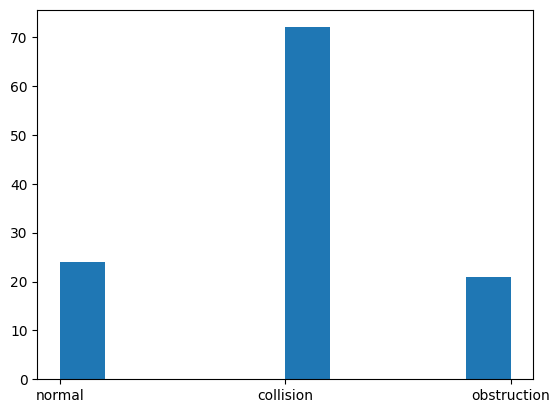

In [5]:
plt.hist(df['position'])

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y , test_size=0.2)

In [14]:
scaler = StandardScaler()
scaler.fit(X)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

Naive Bayes

In [8]:
from sklearn.naive_bayes import GaussianNB


In [9]:
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)
y_pred = nb_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   collision       1.00      0.92      0.96        13
      normal       1.00      1.00      1.00         8
 obstruction       0.75      1.00      0.86         3

    accuracy                           0.96        24
   macro avg       0.92      0.97      0.94        24
weighted avg       0.97      0.96      0.96        24



In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, Y , test_size=0.3, random_state = 42)

KNN model  

In [16]:
from sklearn.neighbors import KNeighborsClassifier

In [17]:
knn_model = KNeighborsClassifier(n_neighbors=4)
knn_model.fit(x_train, y_train)
y_pred = knn_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   collision       0.75      0.75      0.75        20
      normal       0.62      1.00      0.76         8
 obstruction       1.00      0.38      0.55         8

    accuracy                           0.72        36
   macro avg       0.79      0.71      0.69        36
weighted avg       0.78      0.72      0.71        36



Randomforest

In [18]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(criterion='gini', max_depth=8,min_samples_split=10,random_state=5)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   collision       0.80      1.00      0.89        20
      normal       1.00      1.00      1.00         8
 obstruction       1.00      0.38      0.55         8

    accuracy                           0.86        36
   macro avg       0.93      0.79      0.81        36
weighted avg       0.89      0.86      0.84        36



In [20]:
confusion_matrix(y_test, y_pred)

array([[20,  0,  0],
       [ 0,  8,  0],
       [ 5,  0,  3]], dtype=int64)

Artificial neural network

In [22]:
Y.head()

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.3, random_state = 42)

In [28]:
# build a model
model = Sequential()
model.add(Dense(50, input_shape=(x_train.shape[1],), activation='relu')) # input shape is (features,)
model.add(Dense(3, activation='softmax'))

# compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', # this is different instead of binary_crossentropy (for regular classification)
              metrics=['accuracy'])

In [29]:
import keras
from keras.callbacks import EarlyStopping

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10, 
                                   restore_best_weights=True) # important - otherwise you just return the last weigths...

# now we just update our model fit call
history = model.fit(x_train,
                    y_train,
                    callbacks=[es],
                    epochs=200, # you can set this to a big number!
                    batch_size=10,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=0)

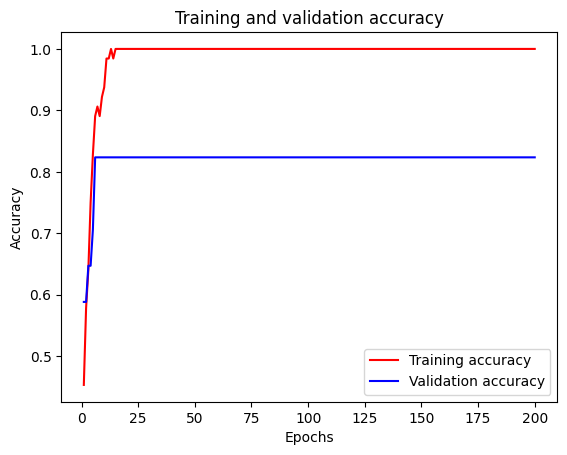

In [30]:
history_dict = history.history

# learning curve
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "r" is for "solid red line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [33]:
y_pred = model.predict(x_test) # see how the model did!
print(y_pred[0]) # i'm spreading that prediction across three nodes and they sum to 1
print(np.sum(y_pred[0])) # sum it up! Should be 1
## [9.9999988e-01 1.3509347e-07 6.7064638e-16]
## 1.0

# Almost a perfect prediction
# actual is left, predicted is top
# names can be found by inspecting Y


2/2 [==============================] - 0s 4ms/step
[0.9739189  0.02170175 0.00437934]
1.0


array([[16,  2,  2],
       [ 0,  8,  0],
       [ 3,  0,  5]], dtype=int64)

In [32]:
# more detail on how well things were predicted
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82        20
           1       0.80      1.00      0.89         8
           2       0.71      0.62      0.67         8

    accuracy                           0.81        36
   macro avg       0.79      0.81      0.79        36
weighted avg       0.80      0.81      0.80        36



In [1]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
matrix

NameError: name 'confusion_matrix' is not defined